In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import tifffile
import pre_process_mm as pre
import mm3_adapted_cell_segmentation as mm3seg
import mm3_adapted_cell_tracking as mm3track
import plot_cells
import growth_curves
from skimage.draw import polygon
from matplotlib.collections import LineCollection
from skimage.measure import find_contours
from skimage import measure
from skimage.measure import regionprops, label
from skimage.io import imread
from scipy.optimize import curve_fit
from scipy.spatial.distance import euclidean
import networkx as nx

In [27]:
def plot_growth_analysis(all_cells_pd, time_col, length_col, folder, fov_id, peak_id,
                         prominence=0.3, distance=3, window_size=3):

    """Analyzes and plots cell growth data with exponential fits for detected phases."""

    cell_df = all_cells_pd.copy()

    growth_phases = growth_curves.detect_growth_phases(cell_df, time_col, length_col, prominence, distance, window_size)

    cell_df = cell_df.assign(y_fit=np.nan, residuals=np.nan, r_squared=np.nan, growth_phase=None, growth_rate_constant=np.nan, doubling_time = np.nan)

    plt.figure(figsize=(10, 6))
    growth_curves._plot_raw_data(cell_df, time_col, length_col, None)

    if not growth_phases:
        plt.title("Cell Data (No Growth Phases Detected)")
        print("No growth phases detected.")
    else:
        for i, (start, end) in enumerate(growth_phases):
            cell_df = growth_curves._process_growth_phase(cell_df, i + 1, start, end, time_col, length_col)

        plt.title(f'Cell Growth Analysis {folder} FOV {fov_id} trench {peak_id}')

    plt.xlabel('Time Frame Index')
    plt.ylabel('Cell Length (pxls)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()

    return cell_df

In [2]:
def _add_time_frame_df(full_region_df, labeled_stack_px_width, mask_kymograph_px_width, x_centroid_col = 'centroid-1'):
    time_frame_pixel_dict = _make_time_frame_pixel_dict(labeled_stack_px_width, mask_kymograph_px_width)
    full_region_df['time_frame'] = full_region_df['centroid-1'].apply(_map_pixel_to_index, range_dict=time_frame_pixel_dict)
    
def _make_time_frame_pixel_dict(labeled_stack_px_width, mask_kymograph_px_width):
    enumerated_x_increments_dict = {index: value for index, value in enumerate(list(range(labeled_stack_px_width, mask_kymograph_px_width+1, labeled_stack_px_width)))}
    time_frame_pixel_dict = {}
    for time_frame, x_limit in enumerated_x_increments_dict.items():
        time_frame_pixel_dict[time_frame] = (x_limit-labeled_stack_px_width, x_limit-1)
    return time_frame_pixel_dict
def _map_pixel_to_index(pixel, range_dict):
    for index, (min_val, max_val) in range_dict.items():
        if min_val <= pixel <= max_val:
            return index
    return None

In [13]:
def plot_kymograph_cells_id(phase_kymograph, fluor_kymograph, full_region_df, folder, fov_id, peak_id, fig_dir, track_id_col='track_id'):
    fig, ax = plt.subplots(2,1, figsize=(40, 10))

    # Get kymograph shape once for both calls
    kymograph_shape = phase_kymograph.shape

    ax[0].imshow(phase_kymograph, cmap = 'grey')
    _plot_cell_masks(ax[0], full_region_df, kymograph_shape, y_coord_col = 'centroid-0', x_coord_col = 'centroid-1', lineage_col = track_id_col)
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    ax[0].set_title(f'Phase Kymograph - {folder} FOV: {fov_id}, trench: {peak_id}')

    ax[1].imshow(fluor_kymograph, cmap = 'grey')
    _plot_cell_masks(ax[1], full_region_df, kymograph_shape, y_coord_col = 'centroid-0', x_coord_col = 'centroid-1', lineage_col = track_id_col)
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_title(f'Fluorescence Kymograph - {folder} FOV: {fov_id}, trench: {peak_id}')

    plt.xlabel("Time frames")
    plt.tight_layout()
    plt.savefig(fig_dir)
    plt.close(fig)

def _plot_cell_masks(ax, full_region_df, kymograph_shape, y_coord_col = 'centroid-0', x_coord_col = 'centroid-1', lineage_col = None):
    default_cell_contour_color = '#AA5486'
    default_centroid_color = '#FC8F54'

    # Prepare data for LineCollection for contours
    all_contours_segments = []
    all_contour_colors = []
    
    # Prepare data for centroids
    centroid_x_coords = []
    centroid_y_coords = []
    centroid_colors = []

    if lineage_col:
        unique_track_ids = full_region_df[lineage_col].dropna().unique()
        colors_cmap = plt.get_cmap('tab20', len(unique_track_ids))
        track_colors = {track_id: colors_cmap(i) for i, track_id in enumerate(unique_track_ids)}

    for index, region_props in full_region_df.iterrows():
        # 'coords' are assumed to be (row, col) pixels within the mask
        cell_pixel_coords = np.array(region_props['coords']) # e.g., [[r1,c1], [r2,c2], ...]

        # Calculate bounding box for the current cell's mask
        min_row, min_col = np.min(cell_pixel_coords, axis=0)
        max_row, max_col = np.max(cell_pixel_coords, axis=0)

        # Create a small temporary mask for the current cell
        # Add a small buffer to ensure contours are fully captured if they go to edge
        buffer = 1
        bbox_min_row = max(0, min_row - buffer)
        bbox_min_col = max(0, min_col - buffer)
        bbox_max_row = min(kymograph_shape[0], max_row + buffer)
        bbox_max_col = min(kymograph_shape[1], max_col + buffer)

        temp_mask_shape = (bbox_max_row - bbox_min_row + 1, bbox_max_col - bbox_min_col + 1)
        temp_mask = np.zeros(temp_mask_shape, dtype=np.uint8)

        # Map cell_pixel_coords to relative coordinates within temp_mask
        relative_rows = cell_pixel_coords[:, 0] - bbox_min_row
        relative_cols = cell_pixel_coords[:, 1] - bbox_min_col
        
        # Populate the temporary mask
        temp_mask[relative_rows, relative_cols] = 1

        # Find contours on this small temporary mask
        # level=0.5 means it finds contours at the boundary between 0 and 1
        # fully_connected='high' means it considers 8-connectivity for background, 4-connectivity for foreground
        contours = find_contours(temp_mask, level=0.5, fully_connected='high')

        if not contours:
            continue # Skip if no contour found (e.g., single pixel or degenerate mask)

        # `find_contours` returns (row, col) coordinates for the contour.
        # We need to convert them back to global kymograph coordinates.
        # And convert to (x, y) for plotting (col, row)
        global_contours = []
        for contour in contours:
            # Shift back to global coordinates and swap for (x, y) plotting
            global_contour_x = contour[:, 1] + bbox_min_col
            global_contour_y = contour[:, 0] + bbox_min_row
            global_contours.append(np.vstack([global_contour_x, global_contour_y]).T)

        y_coord = region_props[y_coord_col]
        x_coord = region_props[x_coord_col]
        
        # Determine color for the current cell
        if lineage_col and region_props[lineage_col] in track_colors:
            current_color = track_colors[region_props[lineage_col]]
        else:
            current_color = default_cell_contour_color

        # Add all contours for this cell to the main list, with the determined color
        for contour_segment in global_contours:
            all_contours_segments.append(contour_segment)
            all_contour_colors.append(current_color)
            
        # Add centroid data
        centroid_x_coords.append(x_coord)
        centroid_y_coords.append(y_coord)
        centroid_colors.append(current_color if lineage_col else default_centroid_color)


    # Plot all cell contours at once using LineCollection
    if all_contours_segments: # Only plot if there are segments to draw
        line_collection = LineCollection(all_contours_segments, colors=all_contour_colors, linewidths=0.5)
        ax.add_collection(line_collection)

    # Plot all centroids at once using scatter
    if centroid_x_coords: # Only plot if there are centroids
        ax.scatter(centroid_x_coords, centroid_y_coords, color=centroid_colors, s=5, zorder=2)

In [4]:
def _create_kymograph(phase_stack, start, end, fov_id, peak_id, output_dir):
    """Creates and saves a kymograph."""
    kymographs_gray = []
    for i in range(start, end):
        phase = phase_stack[i]
        if phase.ndim == 3:
            kymographs_gray.append(np.mean(phase, axis=2))
        else:
            kymographs_gray.append(phase)

    combined_kymograph = np.concatenate(kymographs_gray, axis=1)
    lin_filename = f'{fov_id}_{peak_id}.tif'
    lin_filepath = os.path.join(output_dir, lin_filename)  # Use output_dir
    tifffile.imwrite(lin_filepath, combined_kymograph)
    return combined_kymograph

In [5]:
def link_cells_graph_based(df, max_distance_y=5, max_diff_area_ratio=0.5, area_weight_factor=0.1,  preference_upward_shift=0.5):
    """
    Links cells across multiple frames using a graph-based approach.

    Args:
        df (pd.DataFrame): DataFrame with region properties, including
                           'frame', 'label', 'centroid', 'area'.
        max_distance_centroid (float): Maximum allowed Euclidean distance
                                       between centroids in consecutive frames
                                       to consider a potential link.
        max_diff_area_ratio (float): Maximum allowed ratio of the absolute
                                     difference in area to the average area
                                     to consider a potential link.

    Returns:
        pd.DataFrame: DataFrame with an added 'track_id' column indicating the
                      linked cell track ID.
    """
    if 'time_frame' not in df.columns:
        raise ValueError("DataFrame must have a 'frame' column.")

    unique_frames = sorted(df['time_frame'].unique())
    graph = nx.DiGraph()
    node_id_counter = 0
    node_map = {}  # (frame, label) -> node_id

    # Add nodes for each detection
    for frame in unique_frames:
        frame_df = df[df['time_frame'] == frame].copy()
        for index, row in frame_df.iterrows():
            node_id = node_id_counter
            graph.add_node(node_id, frame=row['time_frame'], label=row['label'],
                           centroid=row['centroid-0'], area=row['area'])
            node_map[(row['time_frame'], row['label'])] = node_id
            node_id_counter += 1

    # Add edges between potential links in consecutive frames
    for i in range(len(unique_frames) - 1):
        current_frame = unique_frames[i]
        next_frame = unique_frames[i + 1]

        current_frame_df = df[df['time_frame'] == current_frame]
        next_frame_df = df[df['time_frame'] == next_frame]

        for _, current_row in current_frame_df.iterrows():
            current_centroid_y = current_row['centroid-0']
            current_area = current_row['area']
            current_node_id = node_map[(current_row['time_frame'], current_row['label'])]

            for _, next_row in next_frame_df.iterrows():
                next_centroid_y = next_row['centroid-0']
                next_area = next_row['area']
                next_node_id = node_map[(next_row['time_frame'], next_row['label'])]

                y_distance = abs(current_centroid_y - next_centroid_y)
                avg_area = (current_area + next_area) / 2
                diff_area_ratio = abs(current_area - next_area) / avg_area if avg_area > 0 else 0

                if y_distance <= max_distance_y and diff_area_ratio <= max_diff_area_ratio:
                    # Add an edge with a weight representing the "cost" of the link
                    # Lower weight means a more likely link
                    weight = y_distance + area_weight_factor * diff_area_ratio
                    # Apply preference for upward shift (smaller y in next frame)
                    if next_centroid_y <= current_centroid_y:
                        weight *= (1 - preference_upward_shift)
                    graph.add_edge(current_node_id, next_node_id, weight=weight)

    # Find tracks as paths through the graph
    tracks = []
    visited_nodes = set()

    for node_id in graph.nodes():
        if node_id not in visited_nodes and not list(graph.predecessors(node_id)):
            # Start a new track from a node with no predecessors
            current_track = [node_id]
            current_node = node_id
            visited_nodes.add(node_id)

            while True:
                successors = list(graph.successors(current_node))
                if not successors:
                    break

                # For simplicity, choose the successor with the minimum weight edge
                best_successor = None
                min_weight = float('inf')
                for successor in successors:
                    weight = graph.get_edge_data(current_node, successor)['weight']
                    if weight < min_weight:
                        min_weight = weight
                        best_successor = successor

                if best_successor is not None:
                    current_track.append(best_successor)
                    visited_nodes.add(best_successor)
                    current_node = best_successor
                else:
                    break
            if current_track:
                tracks.append(current_track)

    # Assign track IDs back to the DataFrame
    df['track_id'] = np.nan
    track_id_counter = 1
    for track in tracks:
        for node_id in track:
            node_info = graph.nodes[node_id]
            frame = node_info['frame']
            label = node_info['label']
            df.loc[(df['time_frame'] == frame) & (df['label'] == label), 'track_id'] = track_id_counter
        track_id_counter += 1

    return df

In [6]:
# select cells starting at t= 28 for fov 005
lineage_FOV_dict = {'DUMM_giTG62_Glucose_012925': 
            {'005': ['445', '900', '1128', '1277', '1887',  '2115', '2344', '2421', '2497']
         }
           }
test_lineage_FOV_dict = {'DUMM_giTG62_Glucose_012925': 
            {'005': ['445']}}

In [14]:
phase_channel = '0'
fluor_channel = '1'
start = 28
end = 175
for folder, fov_dict in lineage_FOV_dict.items():
    all_cells_pd = pd.DataFrame()
    for fov_id in fov_dict.keys():
        ana_peak_ids = fov_dict[fov_id]
        for peak_id in ana_peak_ids:
            path_to_phase_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/subtracted_FOV_{fov_id}_region_{peak_id}_c_{phase_channel}.tif'
            path_to_fluor_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/subtracted_FOV_{fov_id}_region_{peak_id}_c_{fluor_channel}.tif'
            path_to_labeled_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/mm3_segmented_subtracted_FOV_{fov_id}_region_{peak_id}_c_{phase_channel}.tif'
            phase_stack = tifffile.imread(path_to_phase_stack)
            labeled_stack = tifffile.imread(path_to_labeled_stack)
            fluor_stack = tifffile.imread(path_to_fluor_stack)
            phase_output_dir = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted'
            phase_kymograph = _create_kymograph(phase_stack, start, end, fov_id, peak_id, phase_output_dir)
            mask_output_dir = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/mask'
            os.makedirs(mask_output_dir, exist_ok=True)
            mask_kymograph = _create_kymograph(labeled_stack, start, end, fov_id, peak_id, mask_output_dir)
            fluor_output_dir = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/fluor'
            os.makedirs(fluor_output_dir, exist_ok=True)
            fluor_kymograph = _create_kymograph(fluor_stack, start, end, fov_id, peak_id, fluor_output_dir)
            labeled_kymograph_mask = label(mask_kymograph)
            props = measure.regionprops_table(labeled_kymograph_mask, phase_kymograph,
                          properties=['label', 'area', 'coords', 'centroid', 'axis_major_length', 'axis_minor_length',
                                      'intensity_mean', 'intensity_max', 'intensity_min'])
            props_fluor = measure.regionprops_table(labeled_kymograph_mask, fluor_kymograph,
                          properties=['label',
                                      'intensity_mean', 'intensity_max', 'intensity_min'])
            region_phase_df = pd.DataFrame(props)
            region_fluor_df = pd.DataFrame(props_fluor)
            full_region_df = region_phase_df.merge(region_fluor_df, how = 'inner', on = 'label', suffixes = ('_phase', '_fluor'))
            labeled_stack_px_width = labeled_stack.shape[-1]
            mask_kymograph_px_width = mask_kymograph.shape[-1]
            _add_time_frame_df(full_region_df, labeled_stack_px_width, mask_kymograph_px_width, x_centroid_col = 'centroid-1')
            full_region_df['experiment_name']= folder
            full_region_df['FOV']= fov_id
            full_region_df['trench_id']= peak_id
            cells_tracked_df = link_cells_graph_based(full_region_df, max_distance_y=5, max_diff_area_ratio=0.5, area_weight_factor=0.1,  preference_upward_shift=0.5)
            fig_dir = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/cells_detected_{folder}_FOV_{fov_id}_peak_{peak_id}.png'
            plot_kymograph_cells_id(phase_kymograph, fluor_kymograph, 
                                    cells_tracked_df, 
                                    folder, fov_id, peak_id, 
                                    fig_dir, 
                                    track_id_col='track_id')
            if all_cells_pd.empty:
                all_cells_pd = cells_tracked_df
            else:
                all_cells_pd = pd.concat([all_cells_pd, cells_tracked_df], ignore_index=True)
    all_cells_filename = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/all_cell_data_{folder}.pkl'
    all_cells_pd.to_pickle(all_cells_filename)

/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/matplotlib/cbook.py:1072: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)
/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/matplotlib/cbook.py:1072: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)
/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/matplotlib/cbook.py:1072: VisibleDeprecationWarning: Creating an ndarray from ragged nested

In [15]:
bottom_cell_mask = all_cells_pd.groupby(['time_frame', 'FOV', 'trench_id'])['centroid-0'].idxmax()
bottom_cell_df = all_cells_pd.loc[bottom_cell_mask]
# only keep bottom cell at the bottom of the trench
low_bottom_cell_df = bottom_cell_df[bottom_cell_df['centroid-0'] > 200]

In [18]:
low_bottom_cell_df['time_min'] = low_bottom_cell_df['time_frame']*5 

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_75332/1884784248.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_bottom_cell_df['time_min'] = low_bottom_cell_df['time_frame']*5


/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndar

Skipping Phase 15 (540-550): Fit failed or poor R-squared (-0.02).


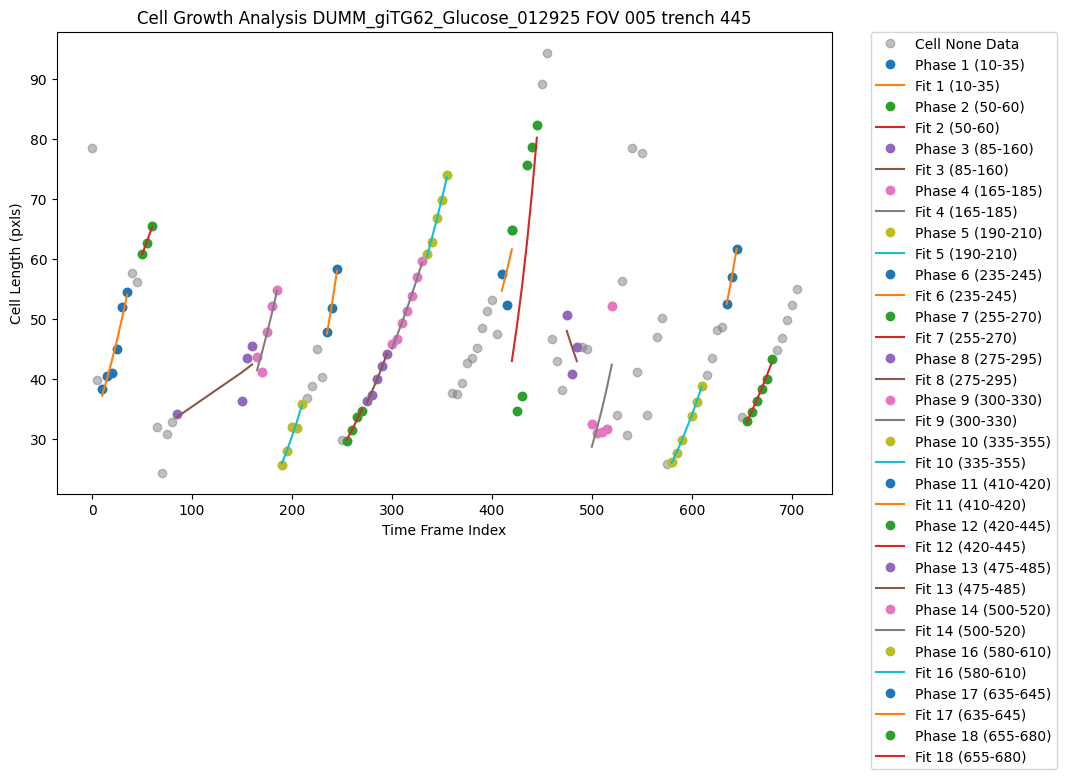

Skipping Phase 4 (165-175): Fit failed or poor R-squared (-0.00).
Skipping Phase 7 (285-295): Fit failed or poor R-squared (0.20).


/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndar

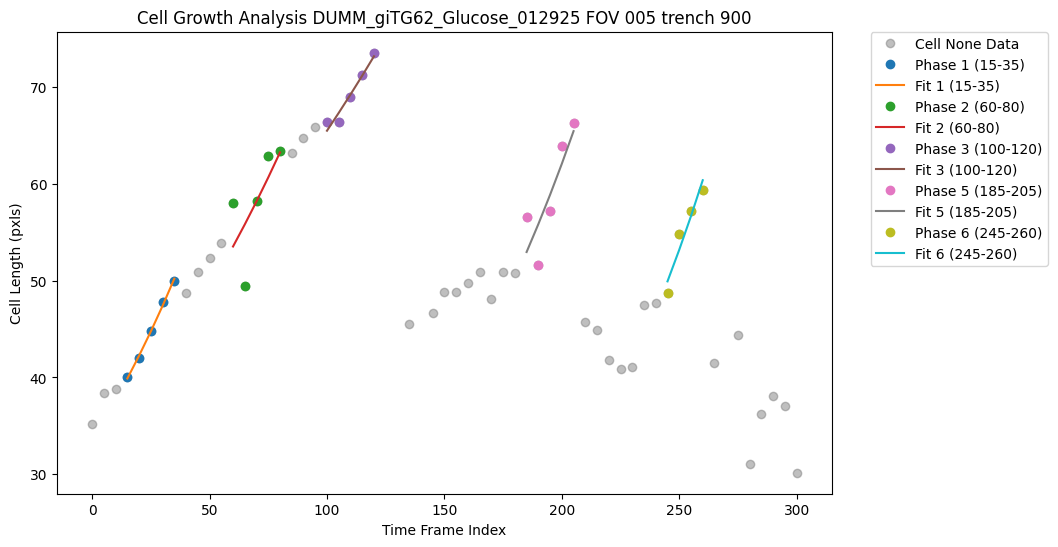

/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndar

Skipping Phase 6 (180-190): Fit failed or poor R-squared (0.07).
Skipping Phase 7 (215-225): Fit failed or poor R-squared (0.08).
Skipping Phase 9 (270-280): Fit failed or poor R-squared (0.26).


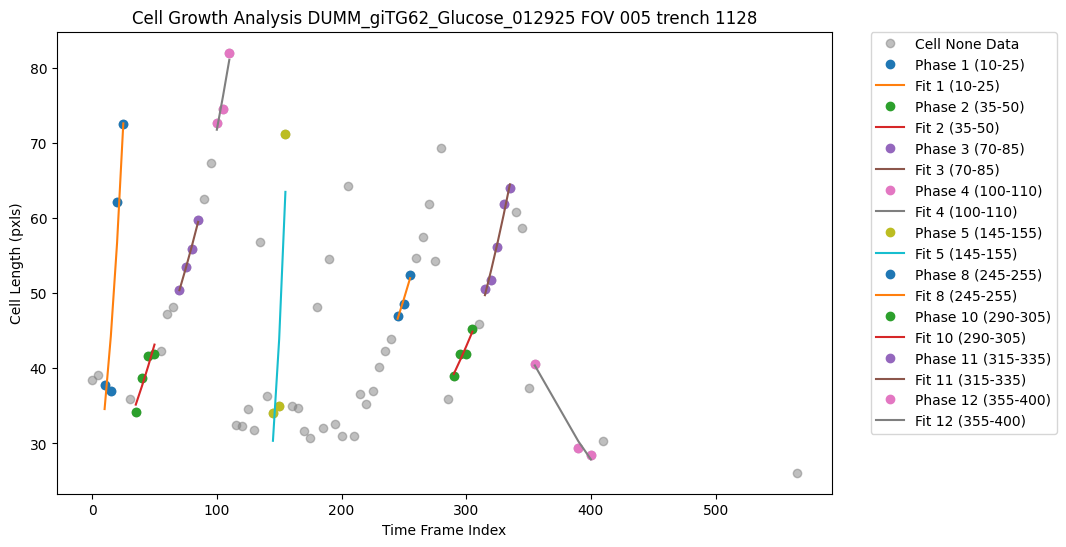

Skipping Phase 3 (80-90): Fit failed or poor R-squared (0.16).
Skipping Phase 7 (190-200): Fit failed or poor R-squared (0.21).
Skipping Phase 12 (385-410): Fit failed or poor R-squared (0.05).
Skipping Phase 15 (515-525): Fit failed or poor R-squared (0.04).
Skipping Phase 17 (615-635): Fit failed or poor R-squared (0.23).


/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndar

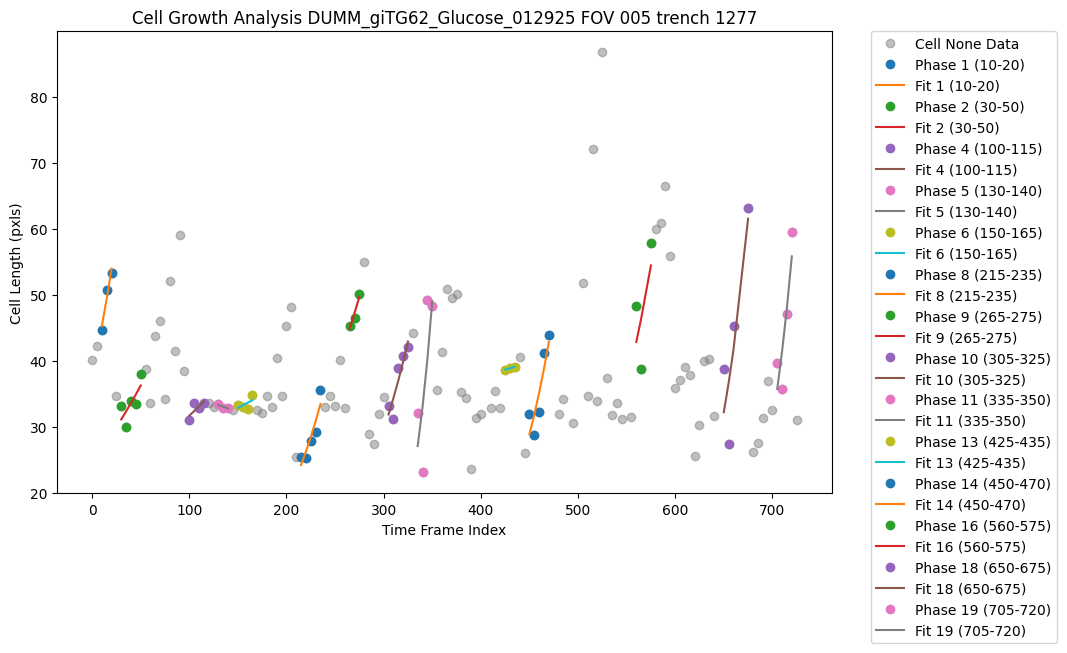

Skipping Phase 2 (155-190): Fit failed or poor R-squared (0.03).
Skipping Phase 4 (255-280): Fit failed or poor R-squared (0.00).
Skipping Phase 7 (435-460): Fit failed or poor R-squared (0.09).


/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndar

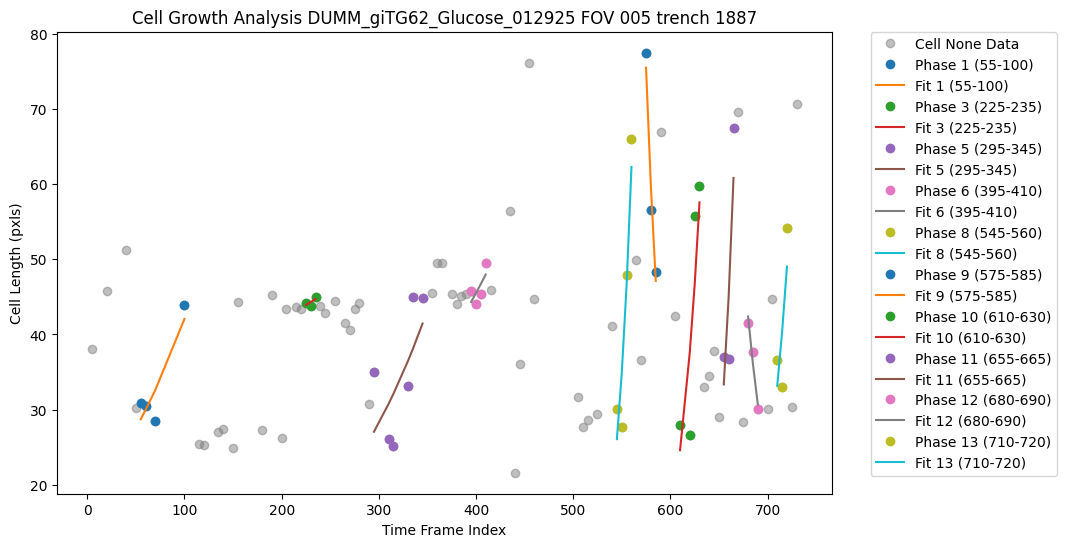

Skipping Phase 4 (105-115): Fit failed or poor R-squared (0.18).


/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndar

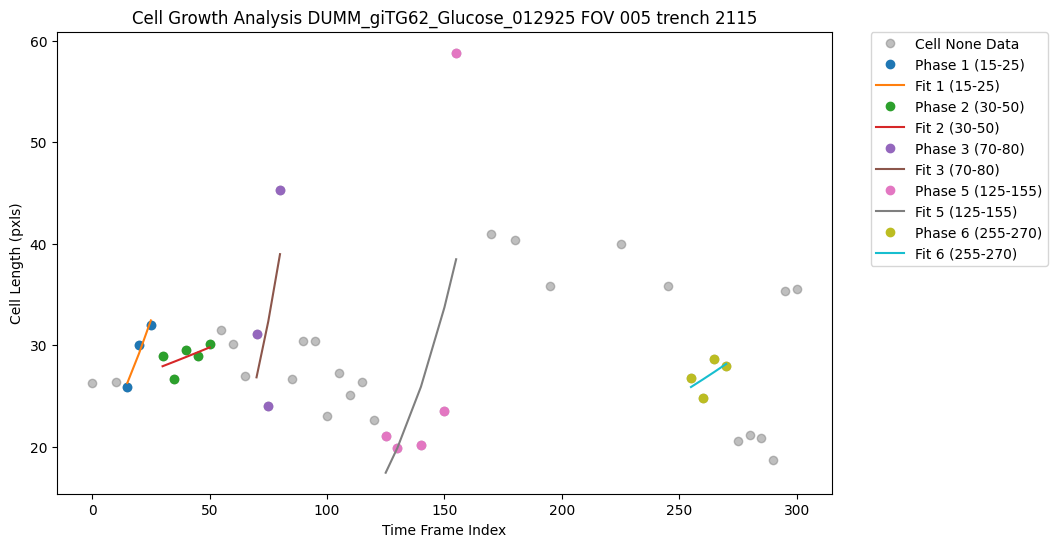

Skipping Phase 7 (340-350): Fit failed or poor R-squared (0.17).
Skipping Phase 11 (475-490): Fit failed or poor R-squared (0.04).
Skipping Phase 13 (565-575): Fit failed or poor R-squared (0.02).
Skipping Phase 17 (680-695): Fit failed or poor R-squared (0.24).


/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndar

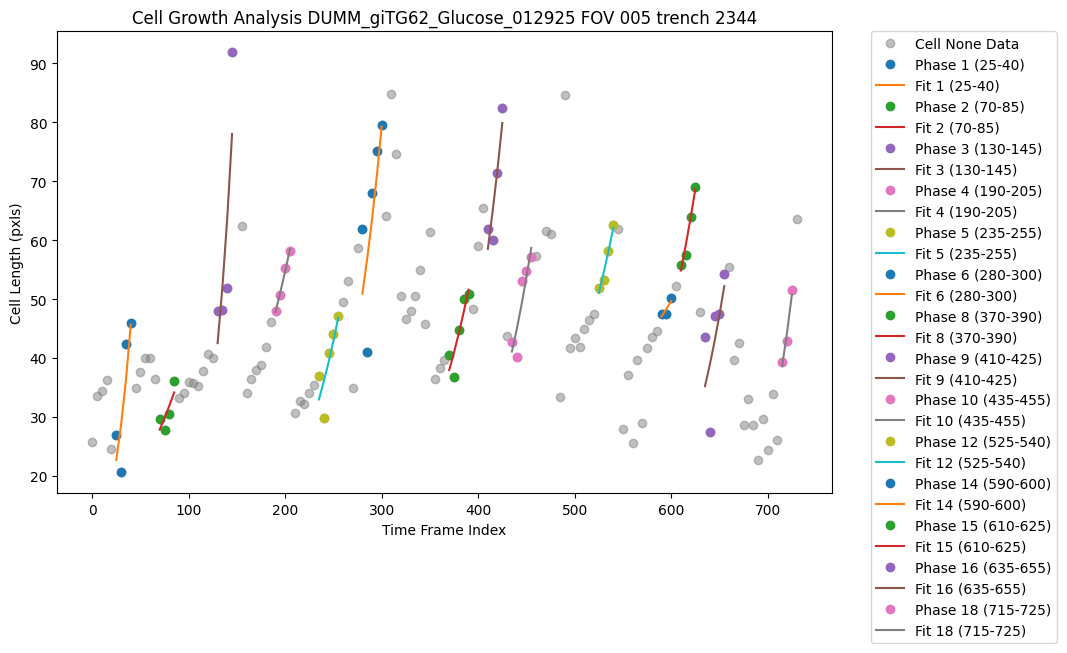

/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndar

Skipping Phase 3 (100-110): Fit failed or poor R-squared (0.12).
Skipping Phase 17 (570-585): Fit failed or poor R-squared (0.15).
Skipping Phase 20 (660-670): Fit failed or poor R-squared (-0.07).


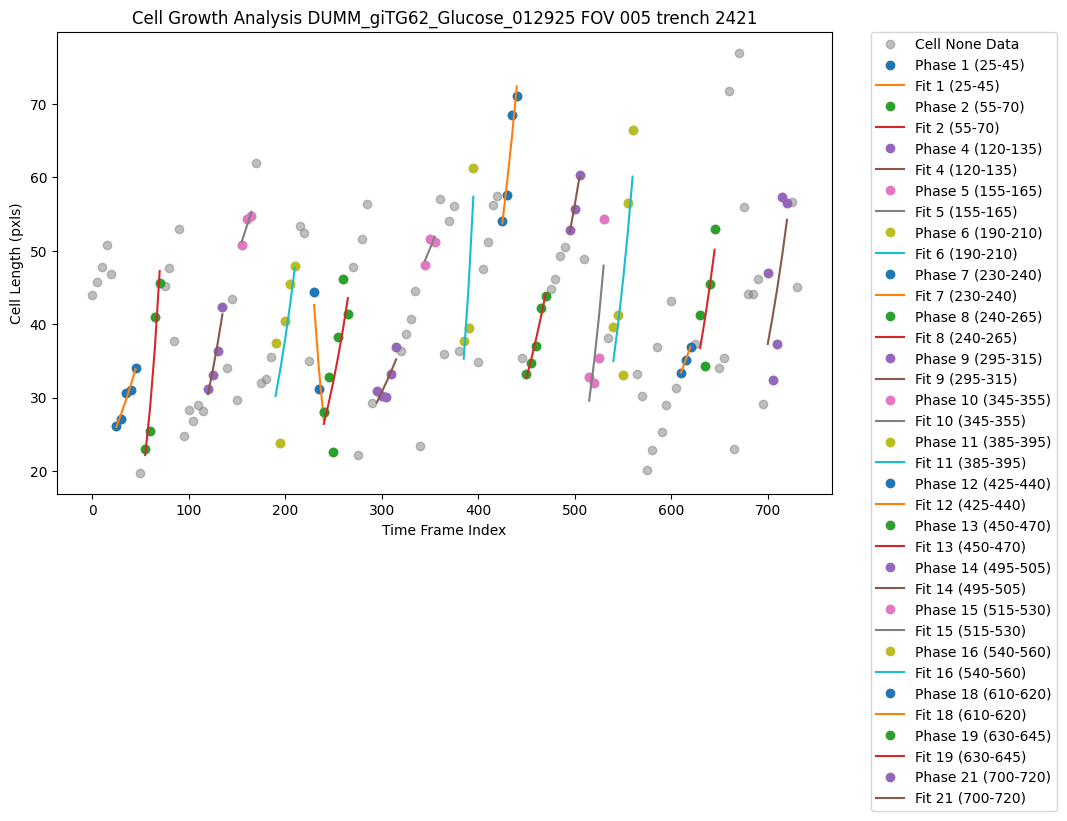

Skipping Phase 9 (305-325): Fit failed or poor R-squared (-0.01).
Skipping Phase 17 (595-620): Fit failed or poor R-squared (0.25).
Skipping Phase 18 (670-680): Fit failed or poor R-squared (0.03).


/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndar

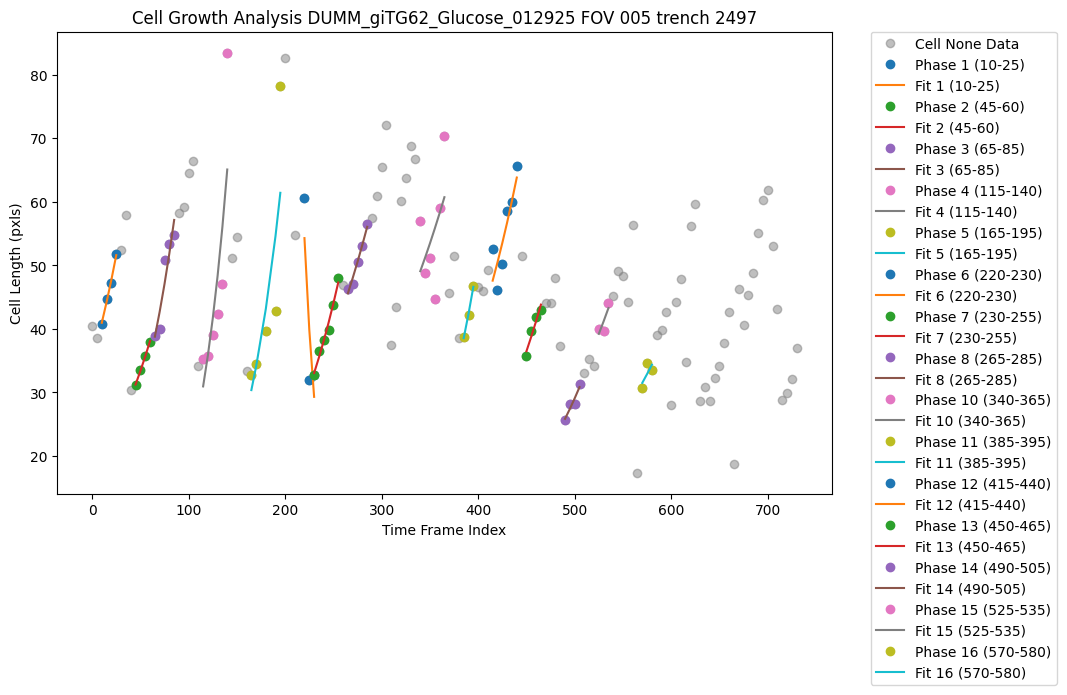

In [26]:
for folder, fov_dict in lineage_FOV_dict.items():
    growth_all_cells_pd = pd.DataFrame()
    for fov_id in fov_dict.keys():
        ana_peak_ids = fov_dict[fov_id]
        for peak_id in ana_peak_ids:
            cells_tracked_df = low_bottom_cell_df[(low_bottom_cell_df['experiment_name']== folder) 
                                                    & (low_bottom_cell_df['FOV']== fov_id)
                                                    & (low_bottom_cell_df['trench_id']== peak_id)]
            #eliminate border detection artifacts
            filtered_cells = cells_tracked_df[cells_tracked_df['axis_major_length'] <100]
            lin_filename = f'{fov_id}_{peak_id}.tif'
            phase_output_dir = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted'
            phase_filepath = os.path.join(phase_output_dir, lin_filename)
            phase_kymograph = tifffile.imread(phase_filepath)
            fluor_output_dir = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/fluor'
            fluor_filepath = os.path.join(fluor_output_dir, lin_filename)
            fluor_kymograph = tifffile.imread(fluor_filepath)
            fig_dir = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/cells_detected_{folder}_FOV_{fov_id}_peak_{peak_id}_bottom_cell.png'
            plot_kymograph_cells_id(phase_kymograph, fluor_kymograph, 
                                    filtered_cells, 
                                    folder, fov_id, peak_id, 
                                    fig_dir, 
                                    track_id_col=None)
            growth_det = plot_growth_analysis(filtered_cells,'time_min', 'axis_major_length',
                                              folder, fov_id, peak_id, prominence=0.1, distance=5, window_size=3);
            if growth_all_cells_pd.empty:
                growth_all_cells_pd = growth_det
            else:
                growth_all_cells_pd = pd.concat([growth_all_cells_pd, growth_det], ignore_index=True)
    growth_all_cells_filename = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/growth_all_cell_data_{folder}.pkl'
    growth_all_cells_pd.to_pickle(growth_all_cells_filename)

In [33]:
# eliminate trenches with poor detection
filtered_growth = growth_all_cells_pd[~growth_all_cells_pd['trench_id'].isin(['1128', '1277', '1887', '2115'])]

cells_growth_rates_pd = filtered_growth[['experiment_name', 'FOV', 'trench_id', 'growth_phase', 'growth_rate_constant', 'doubling_time']].drop_duplicates()
cleaned_growth_cells = cells_growth_rates_pd[(cells_growth_rates_pd['doubling_time'] > 0) & (cells_growth_rates_pd['doubling_time'] < 100)]

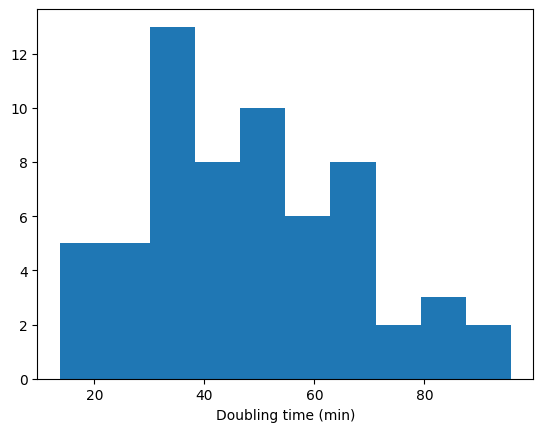

In [36]:
plt.hist(cleaned_growth_cells['doubling_time'].dropna(), bins=10);
plt.xlabel('Doubling time (min)');

In [37]:
filtered_growth.head(10)

,label,area,coords,centroid-0,centroid-1,axis_major_length,axis_minor_length,intensity_mean_phase,intensity_max_phase,intensity_min_phase,...,FOV,trench_id,track_id,time_min,y_fit,residuals,r_squared,growth_phase,growth_rate_constant,doubling_time
0,399,455.0,"[[212, 10], [212, 11], [213, 8], [213, 9], [21...",246.545055,10.129670,78.456871,8.229023,9316.916484,14675.0,6416.0,...,005,445,4.0,0,NaN,NaN,NaN,None,NaN,NaN
1,484,278.0,"[[244, 30], [244, 31], [245, 29], [245, 30], [...",262.906475,30.863309,39.894149,9.289313,9076.812950,11942.0,6316.0,...,005,445,6.0,5,NaN,NaN,NaN,None,NaN,NaN
2,487,257.0,"[[245, 48], [245, 49], [245, 50], [246, 47], [...",263.038911,50.459144,38.433931,9.203065,9119.735409,12745.0,6344.0,...,005,445,6.0,10,37.297108,1.136823,0.943201,Phase 1 (10-35),0.014863,46.637192
3,483,276.0,"[[242, 68], [243, 67], [243, 68], [243, 69], [...",261.387681,69.536232,40.539401,9.333634,8986.934783,12524.0,6344.0,...,005,445,6.0,15,40.174341,0.365060,0.943201,Phase 1 (10-35),0.014863,46.637192
4,475,237.0,"[[238, 88], [238, 89], [238, 90], [239, 88], [...",257.421941,89.493671,41.119405,7.742658,8998.151899,12621.0,6496.0,...,005,445,6.0,20,43.273533,-2.154129,0.943201,Phase 1 (10-35),0.014863,46.637192
5,476,284.0,"[[238, 108], [238, 109], [239, 107], [239, 108...",259.630282,110.204225,45.005303,8.868719,9205.369718,12953.0,6514.0,...,005,445,6.0,25,46.611809,-1.606505,0.943201,Phase 1 (10-35),0.014863,46.637192
6,470,319.0,"[[235, 127], [235, 128], [235, 129], [235, 130...",258.291536,129.435737,52.101253,8.677191,9210.219436,13076.0,6473.0,...,005,445,6.0,30,50.207610,1.893643,0.943201,Phase 1 (10-35),0.014863,46.637192
7,467,352.0,"[[233, 148], [233, 149], [233, 150], [234, 147...",258.775568,150.502841,54.626593,9.039923,9168.360795,11548.0,6673.0,...,005,445,6.0,35,54.080805,0.545788,0.943201,Phase 1 (10-35),0.014863,46.637192
8,454,353.0,"[[229, 168], [229, 169], [230, 167], [230, 168...",255.994334,169.883853,57.747385,8.893638,9226.099150,12246.0,6838.0,...,005,445,6.0,40,NaN,NaN,NaN,None,NaN,NaN
9,455,394.0,"[[229, 187], [229, 188], [229, 189], [230, 187...",255.428934,190.984772,56.135926,9.654079,9227.065990,11808.0,6831.0,...,005,445,6.0,45,NaN,NaN,NaN,None,NaN,NaN


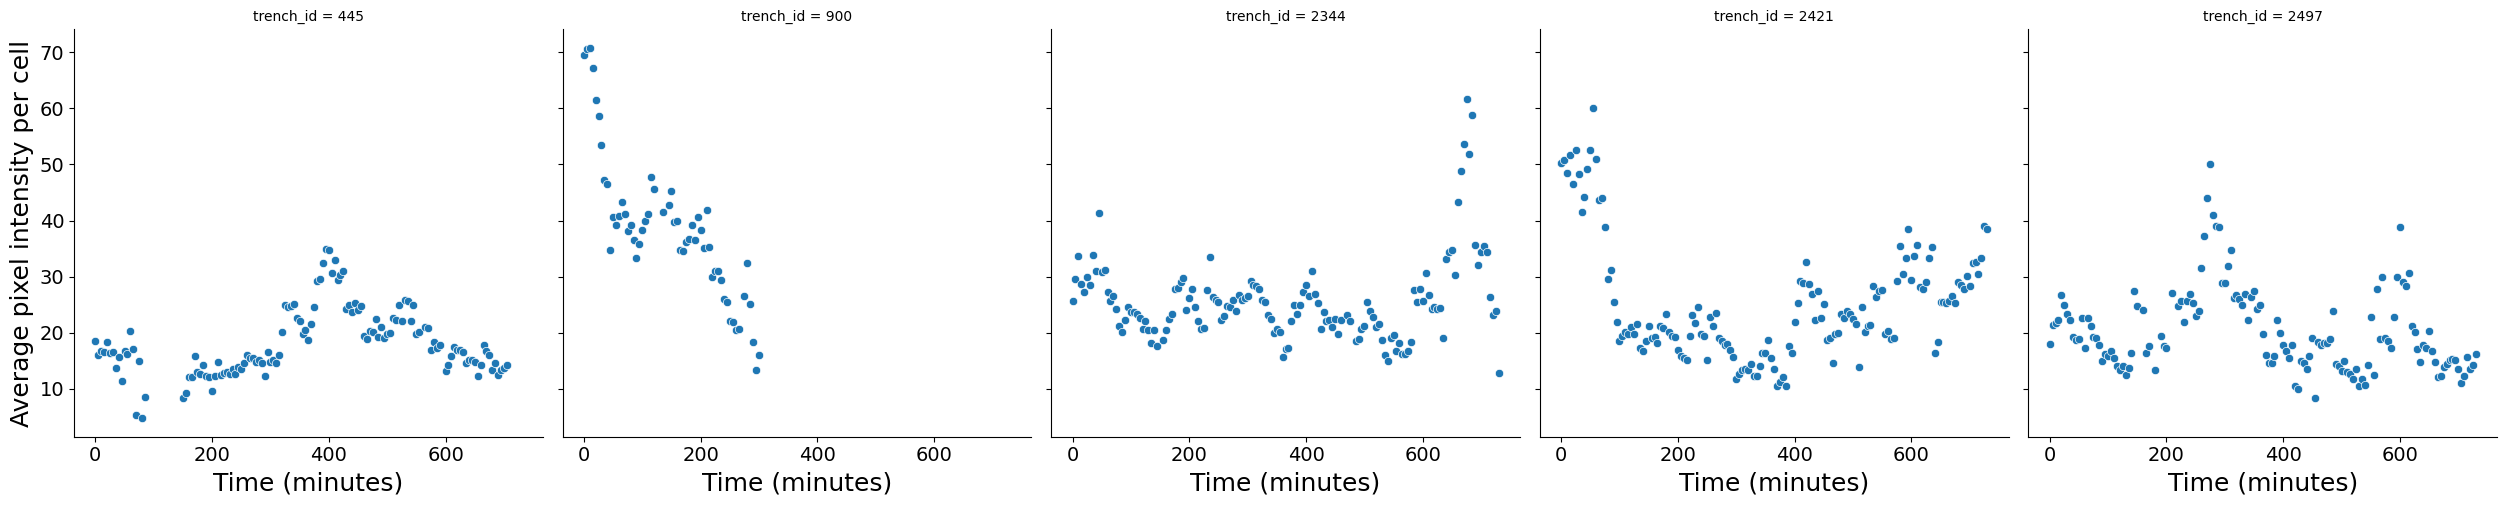

In [39]:
g = sns.relplot(data=filtered_growth, x= 'time_min', y= 'intensity_mean_fluor',
             col = 'trench_id',col_wrap = 5)
# Increase x-axis label font size
g.set_axis_labels(x_var='Time (minutes)', y_var= 'Average pixel intensity per cell', fontsize=18)
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

sns.despine();